# FYS-STK4155 - Project 1 Notebook

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

seed = 2021
np.random.seed(seed)

## a)

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def MSE(y, y_tilde):
    n = len(y)
    return np.sum(y - y_tilde)**2 / n

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - np.mean(y_data)) **2)

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

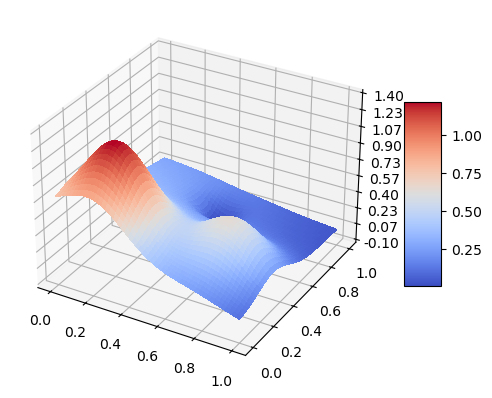

In [3]:

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

n = 5
N = 2000
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
N = 1000
x = np.arange(0, 1, 1/N).reshape(-1, 1) 
y = np.arange(0, 1, 1/N).reshape(-1, 1)
z = FrankeFunction(x, y) + np.random.normal(0, 0.1, (N, N))

MSE_raw = []
MSE_scaled = []
R2_raw = []
R2_scaled = []
β_raw_list = []
β_scaled_list = []

degrees = range(1, 6)
for degree in degrees:
    X = create_X(x, y, n=degree)
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=seed)

    # Raw
    β_raw = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    β_raw_list.append(β_raw)
    y_tilde_raw = X_train @ β_raw 
    y_pred_raw = X_test @ β_raw
    
    MSE_raw.append(MSE(y_train, y_tilde_raw))
    R2_raw.append(R2(y_test, y_pred_raw))
    
    # Scaled
    scaler_X = StandardScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler().fit(y_train)
    y_train_scaled = scaler_y.transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    β_scaled = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled
    β_scaled_list.append(β_scaled)
    y_tilde_scaled = X_train_scaled @ β_scaled 
    y_pred_scaled = X_test_scaled @ β_scaled
    
    MSE_scaled.append(MSE(y_train_scaled, y_tilde_scaled))
    R2_scaled.append(R2(y_test_scaled, y_pred_scaled))

MSE(R2_raw, R_scaled) = 8.36e-11


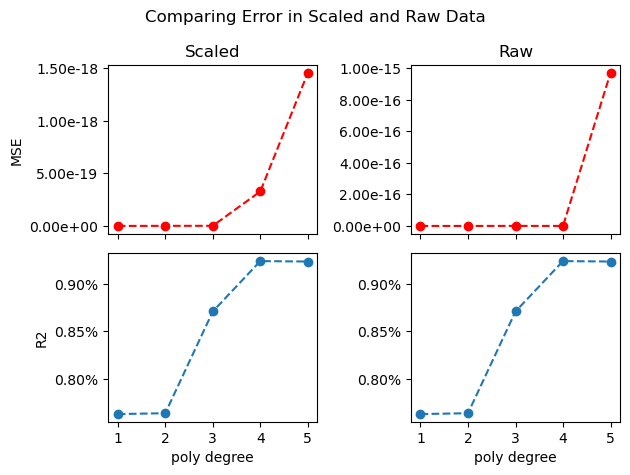

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True)

# Plotting in grid
ax1[0].plot(degrees, MSE_scaled, "r--o")
ax1[0].set_title("Scaled")

ax1[1].plot(degrees, MSE_raw, "r--o")
ax1[1].set_title("Raw")

ax2[0].plot(degrees, R2_scaled, "--o")
ax2[1].plot(degrees, R2_raw, "--o")

print(f'MSE(R2_raw, R_scaled) = {MSE(np.array(R2_raw), np.array(R2_scaled)):.2e}') # Almost equal

# Prettifying
## Formatting y-labels
ax1[0].yaxis.set_major_formatter(FormatStrFormatter("%.2e"))
ax1[1].yaxis.set_major_formatter(FormatStrFormatter("%.2e"))

ax2[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f%%"))
ax2[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f%%"))

## Axis labels
ax2[0].set_xlabel('poly degree')
ax2[1].set_xlabel('poly degree')
ax1[0].set_ylabel('MSE')
ax2[0].set_ylabel('R2')

plt.suptitle("Comparing Error in Scaled and Raw Data")
plt.tight_layout()
plt.savefig("../figs/a_error_scaled_vs_raw.pdf")
plt.show()

### Comment on Plot
- We get less errors with scaled data, by three orders of magnitude. 
- MSE is very low until we reach 4th degree polynomial for the scaled data, while for the unscaled data it is low until we reach 5th degree polynomial.
- The R2 score increases with the degree of the polynomial for both scaled and unscaled data, and have a MSE ∝ $10^{-11}$

MSE between first and last row:  5.34e-06
MSE between first and last row:  1.30e-04
MSE between first and last row:  1.08e-04
MSE between first and last row:  1.20e-04
MSE between first and last row:  1.11e-04


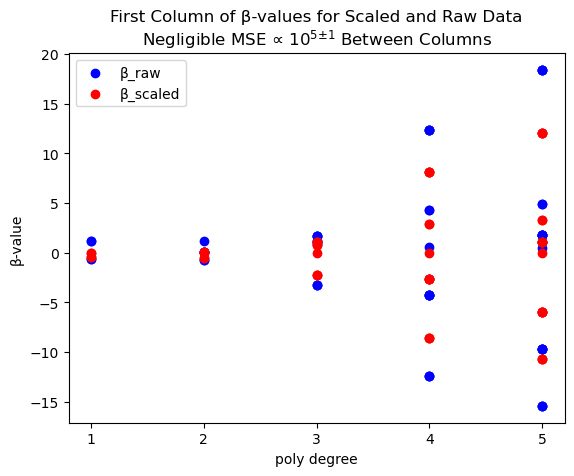

In [6]:
for i, deg in enumerate(degrees):
    diff = MSE(β_raw_list[i][:, 0], β_raw_list[i][:, -1]) # Comparing first and last row
    print(f'MSE between first and last row: {diff: .2e}')
    m = len(β_raw_list[i][:, 0]) # Choice of row in β makes basically no difference
    plt.scatter([deg]*m, β_raw_list[i][:, 0], c='blue')
    plt.scatter([deg]*m, β_scaled_list[i][:, 0], c='red')

# Single data point for labels
plt.scatter(1, β_raw_list[0][0, 0], c='blue', label="β_raw")
plt.scatter(1, β_scaled_list[0][0, 0], c='red', label="β_scaled")

plt.title("First Column of β-values for Scaled and Raw Data\nNegligible MSE ∝ $10^{5±1}$ Between Columns")
plt.xlabel("poly degree")
plt.ylabel('β-value')
plt.xticks([i for i in degrees], [str(i) for i in degrees])
plt.legend()
plt.savefig("../figs/a_beta_scaled_vs_raw.pdf")
plt.show()

### Comment on Plot
- As we increase the degree of the polynomial, we see a wider range of $β$-values. 
- The scaled values are consistently tighter in spread than the raw values.
- There are a small difference in β-values in each row of the β-matrices, but the difference is non significant.
- Difference in β-values from each row is most likely due to the use of pseudo-inverse in the OLS estimation.

#### Open Questions
- What does this mean for the model?
- Is pinv the cause of the difference in β-values?